## **Distracted Driving Detection Using CNN**

##### A CNN-based real-time object detection system to identify distracted driving behaviors like texting, phone use, and drinking using annotated images from the State Farm dataset.

In [1]:
pip install tensorflow

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import os, random, math, shutil
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import itertools
from collections import Counter
from glob import glob 

In [3]:
class_map = {
    'c0': 'Safe Driving',
    'c1': 'Texting - Right',
    'c2': 'Talking on the Phone - Right',
    'c3': 'Texting - Left',
    'c4': 'Talking on the Phone - Left',
    'c5': 'Operating the Radio',
    'c6': 'Drinking',
    'c7': 'Reaching Behind',
    'c8': 'Hair and Makeup',
    'c9': 'Talking to Passenger'
}

In [4]:
# Paths
DATA_DIR = "imgs/train"
OUTPUT_DIR = "./outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Reproducibility
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Basic settings
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 15  # start modest; you can raise after it works
VAL_SPLIT = 0.15  # 15% validation from training

# Class names (fixed by dataset)
CLASS_NAMES = [f"c{i}" for i in range(10)]
print("Classes:", CLASS_NAMES)

# Sanity check: make sure folders exist
assert all(os.path.isdir(os.path.join(DATA_DIR, c)) for c in CLASS_NAMES), \
    "Expected c0..c9 folders under DATA_DIR. Please check DATA_DIR."

# Collect image files (all jpgs, recursively)
image_files = glob(os.path.join(DATA_DIR, "**/*.jpg"), recursive=True)
print(f"Found {len(image_files)} images.")

Classes: ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']
Found 22424 images.


Found 22424 files belonging to 10 classes.
Using 19061 files for training.
Found 22424 files belonging to 10 classes.
Using 3363 files for validation.


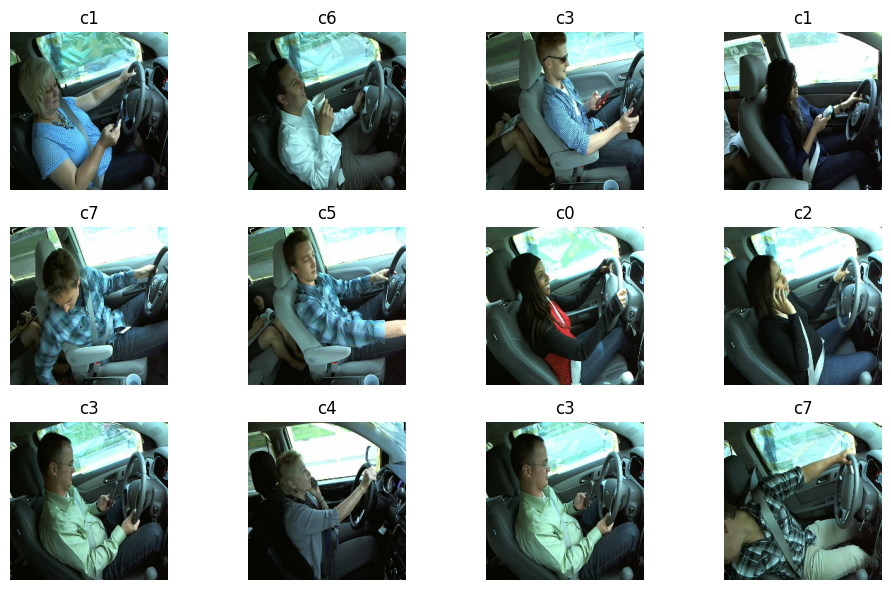

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    labels='inferred',
    label_mode='int',
    class_names=CLASS_NAMES,
    validation_split=VAL_SPLIT,
    subset='training',
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    labels='inferred',
    label_mode='int',
    class_names=CLASS_NAMES,
    validation_split=VAL_SPLIT,
    subset='validation',
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# Improve performance with caching & prefetching
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.shuffle(1000).prefetch(AUTOTUNE)
val_ds   = val_ds.prefetch(AUTOTUNE)

# Peek at a few samples
for imgs, labels in train_ds.take(1):
    plt.figure(figsize=(10,6))
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.imshow(imgs[i].numpy().astype("uint8"))
        plt.title(CLASS_NAMES[labels[i].numpy()])
        plt.axis("off")
    plt.tight_layout()
    plt.show()

In [6]:
def get_class_counts(data_dir, class_names):
    counts = {}
    for c in class_names:
        folder = os.path.join(data_dir, c)
        counts[c] = len([f for f in os.listdir(folder) if f.lower().endswith(('.jpg','.jpeg','.png'))])
    return counts

counts = get_class_counts(DATA_DIR, CLASS_NAMES)
print("Image counts per class:", counts)

total = sum(counts.values())
class_weight = {}
for idx, c in enumerate(CLASS_NAMES):
    # Inverse frequency: more weight to underrepresented classes
    class_weight[idx] = total / (len(CLASS_NAMES) * counts[c])
print("Class weights:", class_weight)

Image counts per class: {'c0': 2489, 'c1': 2267, 'c2': 2317, 'c3': 2346, 'c4': 2326, 'c5': 2312, 'c6': 2325, 'c7': 2002, 'c8': 1911, 'c9': 2129}
Class weights: {0: 0.9009240658899156, 1: 0.9891486546096162, 2: 0.9678031937850669, 3: 0.9558397271952259, 4: 0.9640584694754945, 5: 0.9698961937716263, 6: 0.9644731182795699, 7: 1.12007992007992, 8: 1.1734170591313449, 9: 1.0532644434006575}


In [7]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
], name="augmentation")

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [8]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights="imagenet"
)
base_model.trainable = False  # start by freezing the backbone

inputs = keras.Input(shape=IMG_SIZE + (3,))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.25)(x)
outputs = layers.Dense(len(CLASS_NAMES), activation="softmax")(x)
model = keras.Model(inputs, outputs)

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ augmentation (Sequential)            │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide (TrueDivide)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract (Subtract)                  │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 10)                  │          12,810 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,270,794 (8.66 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [9]:
checkpoint_path = os.path.join(OUTPUT_DIR, "best_model.keras")
callbacks = [
    keras.callbacks.ModelCheckpoint(
        checkpoint_path, monitor="val_accuracy", save_best_only=True, verbose=1
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy", patience=3, restore_best_weights=True, verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=2, verbose=1, min_lr=1e-6
    )
]

In [10]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    class_weight=class_weight,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/15
596/596 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3839 - loss: 1.8027
Epoch 1: val_accuracy improved from -inf to 0.67648, saving model to ./outputs\best_model.keras
596/596 ━━━━━━━━━━━━━━━━━━━━ 1115s 2s/step - accuracy: 0.3842 - loss: 1.8020 - val_accuracy: 0.6765 - val_loss: 0.9644 - learning_rate: 0.0010
Epoch 2/15
596/596 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7239 - loss: 0.8597
Epoch 2: val_accuracy improved from 0.67648 to 0.73744, saving model to ./outputs\best_model.keras
596/596 ━━━━━━━━━━━━━━━━━━━━ 930s 1s/step - accuracy: 0.7240 - loss: 0.8596 - val_accuracy: 0.7374 - val_loss: 0.8164 - learning_rate: 0.0010
Epoch 3/15
596/596 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7743 - loss: 0.7011
Epoch 3: val_accuracy improved from 0.73744 to 0.79037, saving model to ./outputs\best_model.keras
596/596 ━━━━━━━━━━━━━━━━━━━━ 963s 1s/step - accuracy: 0.7743 - loss: 0.7011 - val_accuracy: 0.7904 - val_loss: 0.6617 - learning_rate: 0.0010
Epoch 4/15
596/596 ━━━━━

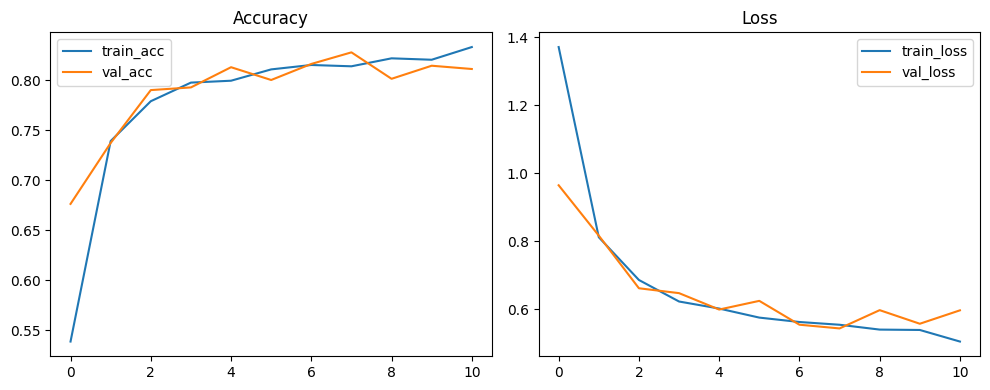

In [11]:
def plot_curves(h):
    plt.figure(figsize=(10,4))
    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(h.history['accuracy'], label='train_acc')
    plt.plot(h.history['val_accuracy'], label='val_acc')
    plt.title('Accuracy')
    plt.legend()
    # Loss
    plt.subplot(1,2,2)
    plt.plot(h.history['loss'], label='train_loss')
    plt.plot(h.history['val_loss'], label='val_loss')
    plt.title('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_curves(history)

In [14]:
model.save("distracted_driver_detector.keras")
print("Classes:", class_map)

Classes: {'c0': 'Safe Driving', 'c1': 'Texting - Right', 'c2': 'Talking on the Phone - Right', 'c3': 'Texting - Left', 'c4': 'Talking on the Phone - Left', 'c5': 'Operating the Radio', 'c6': 'Drinking', 'c7': 'Reaching Behind', 'c8': 'Hair and Makeup', 'c9': 'Talking to Passenger'}


### Testing with the best model 

In [69]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from PIL import Image

# Load trained model (has preprocess inside)
model = keras.models.load_model("distracted_driver_detector.keras")

# Ordered list of classes (index 0 = c0, index 1 = c1, ...)
class_names = [
    'Safe Driving', 
    'Texting - Right', 
    'Talking on the Phone - Right', 
    'Texting - Left', 
    'Talking on the Phone - Left', 
    'Operating the Radio', 
    'Drinking', 
    'Reaching Behind', 
    'Hair and Makeup', 
    'Talking to Passenger'
]

def predict_image(path, top_k=2):
    img = Image.open(path).convert("RGB").resize((224,224))
    x = np.array(img, dtype=np.float32)        # raw float32, 0..255
    x = tf.convert_to_tensor(x)[None, ...]     # (1,224,224,3)

    # forward pass
    logits = model(x, training=False)          
    probs = tf.nn.softmax(logits, axis=-1).numpy()[0]

    # top-k indices sorted by probability
    top_idxs = np.argsort(-probs)[:top_k]
    results = [(class_names[i], float(probs[i])) for i in top_idxs]
    return results

# Example: get top-2 suggestions
preds = predict_image("img_10.jpg", top_k=2)
for label, conf in preds:
    print(label, round(conf, 3))


Safe Driving 0.153
Operating the Radio 0.107
